# FIFA 18 Overall Rating Analysis

### Background
A common post on reddit.com/r/fifa questions the discrepancy between player stats and overall rating. Take Gerard Piqué and Moussa Sissoko for example

<table>
    <tr>
        <td><img src="./images/pique.jpg" alt="Pique" style="width: 150px;"/></td>
        <td style="width:100px"> </td>
        <td><img src="./images/sissoko.jpg" alt="Sissoko" style="width: 150px;"/></td>
    <tr>
</table>

Sissoko has better card stats in every category except defending, yet is rated 10 overall lower than Piqué. Let’s take away international reputation for the moment, and look at actual ratings per position (according to https://www.futbin.com). Pique is an 84 rated CB, and Sissoko a 76 rated RM. Sissoko is still 8 overall ratings lower than Piqué despite his superior stats. Obviously, they are in different positions, but how much does that really matter? Piqué is an 87 rated CB and none of his stats are equal to or above that. This analysis aims solve this mystery using machine learning.

To eliminate unnecessary excess data, I combined positions into 5 categories. A table can be seen below, and that notation is used throughout. 

<table>
    <tr>
        <td style="text-align:left">FIFA Position</td>
        <td style="text-align:left">Label</td>
    </tr>    
    <tr>
        <td style="text-align:left">CB</td>
        <td>cb (center-back)</td>
    </tr>
        <tr>
        <td style="text-align:left">LB, LWB, RB, RWB</td>
        <td>wb (wing-back)</td>
    </tr>
        <tr>
        <td style="text-align:left">CAM, CM, CDM</td>
        <td>mid (midfielder)</td>
    </tr>
        <tr>
        <td style="text-align:left">LM, LW, RM, RW</td>
        <td>wing (winger)</td>
    </tr>
        <tr>
        <td style="text-align:left">LF, RF, CF ,ST</td>
        <td>st (stiker)</td>
    </tr>
</table>

NOTE 1: a player’s position is based on their preferred position (not their FUT position necessarily). Some players have multiple preferred positions in multiple categories. For example, Cristiano Ronaldo has both LW and ST as preferred position. One of these duplicates is dropped at random to make the data set more general. 

NOTE 2: Only normal cards were used, no special cards (In-forms, TOTY, MOTM, Icons etc.) were used.

### If you don't care about the technical stuff, skip down to the Analysis Section

## Approach
The two approaches I took were to look at classifying player position, and making a regression of their overall rating (more on the position classification can be seen at https://www.kaggle.com/zachdunkerton/position-and-similar-player-predictions). The thought behind this was to see what in-game stats made different positions unique, and what in-game stats affected overall rating. 

Random Forests were used for both approaches. To classify position, I labeled each player according to preferred position as described above, and then used Sklearn's RandomForestClassifier with these positions as the labels. For the regression, Sklearn's RandomForestRegressor was used with the player's overall rating as the label.

This analysis is based off the feature importances each algorithm yields. When the players are classified by position, or run through a regression, the Random Forests allow the most important features (in-game stats) to be analyzed. By looking at which in-games are most significant, we can gain insight into the rating system.

Import all the things

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

Data source: https://www.kaggle.com/kevinmh/fifa-18-more-complete-player-dataset 

In [85]:
fifa = pd.read_csv("./complete.csv")
#fifa = pd.read_csv("../input/complete.csv")
fifa = fifa.rename(columns={'age': 'position'})

This analysis was based on the "in-game" stats of the player, not their "base-card" stats pictured above.

In [30]:
in_games = ["acceleration","sprint_speed", "positioning",
                                   "finishing","shot_power","long_shots","volleys",
                                   "penalties","vision","crossing","free_kick_accuracy",
                                   "short_passing","long_passing","curve","agility",
                                   "balance","reactions","ball_control","dribbling",
                                   "composure","interceptions","heading_accuracy","marking",
                                   "standing_tackle","sliding_tackle","jumping","stamina","strength","aggression"]

Label the positions of each player

In [93]:
cb = pd.DataFrame(fifa.loc[(fifa["prefers_cb"]==True)])
cb['position'] = 0

wb = pd.DataFrame(fifa.loc[(fifa["prefers_rb"]==True)|(fifa["prefers_lb"]==True)|(fifa["prefers_rwb"]==True)|(fifa["prefers_lwb"]==True)])
wb['position'] = 1

mid = pd.DataFrame(fifa.loc[(fifa["prefers_cdm"]==True)|(fifa["prefers_cm"]==True)|(fifa["prefers_cam"]==True)])
mid['position'] = 2

wingers = pd.DataFrame(fifa.loc[(fifa["prefers_lm"]==True)|(fifa["prefers_rm"]==True)|(fifa["prefers_lw"]==True)|(fifa["prefers_rw"]==True)])
wingers['position'] = 3

st = pd.DataFrame(fifa.loc[(fifa["prefers_st"]==True)|(fifa["prefers_cf"]==True)|(fifa["prefers_lf"]==True)|(fifa["prefers_rf"]==True)])
st['position'] = 4

data = [cb,wb,st,mid, wingers]
result = pd.concat(data)
result = result.sort_values('overall', ascending=False)
result = result.drop_duplicates('name')
position_fifa = result.loc[:,["name","club_logo","flag","photo" ,"acceleration",
                       "sprint_speed", "positioning","finishing","shot_power",
                       "long_shots","volleys","penalties","vision","crossing",
                       "free_kick_accuracy","short_passing","long_passing","curve",
                       "agility","balance","reactions","ball_control","dribbling",
                       "composure","interceptions","heading_accuracy","marking",
                       "standing_tackle","sliding_tackle","jumping","stamina",
                       "strength","aggression", "position"]]

### Position Classifier
Now that we have our data, lets run the classifier and see if our results are good enough to take any significance from the feature weights. 

In [100]:
position_data = position_fifa.iloc[:, 4:33]
position_labels = position_fifa["position"]

In [99]:
features_train, features_test, labels_train, labels_test = train_test_split(position_data, position_labels, test_size=0.2, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators = 500,criterion = 'entropy', min_samples_split = 2,min_samples_leaf = 5, max_depth=20)
rnd_clf.fit(features_train, labels_train)
pred = rnd_clf.predict(features_test)
print(accuracy_score(labels_test,pred))
target_names = ['cb', 'wb', 'mid','wing','st']
print(classification_report(labels_test,pred, target_names = target_names))

0.7787318361955086
             precision    recall  f1-score   support

         cb       0.83      0.84      0.83       528
         wb       0.76      0.79      0.77       522
        mid       0.77      0.79      0.78       902
       wing       0.70      0.61      0.65       574
         st       0.85      0.87      0.86       502

avg / total       0.78      0.78      0.78      3028



The cb and st positions yield the best results. This is not unexpected, because they tend to have different stats than other positions. Specifically, defenders have high defending and strikers have high shooting. This helps distinguish them from other positions. Wing backs and wingers can have similar stats, and midfielders cover the whole spectrum, so it is not surprising that their scores were worse. Wingers in particular are hard to classify because some are very similar to midfielders, and others are very similar to attackers. However, the baseline is 20% (random guessing), so the model performs decently well. 

Now we need to train it on all the data. This is the model we use to obtain the feature importances. 

In [4]:
position_rnd_clf = RandomForestClassifier(n_estimators = 250, min_samples_split = 10,min_samples_leaf = 5, max_depth=7)
position_rnd_clf.fit(position_data, position_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Overall Rating Regression
As before, we will train a model and see what kind of results we get.

In [9]:
overall_labels = result["overall"]
overall_data = result.loc[:,in_games]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(overall_data, overall_labels,test_size=.2)

overall_rnd_clf = RandomForestRegressor(n_estimators = 100, max_depth=50, min_samples_leaf=2, min_samples_split=2)
overall_rnd_clf.fit(X_train, y_train)
pred = overall_rnd_clf.predict(X_test)
print("%.2f" %(mean_absolute_error(y_test,pred)))

1.04


Very good result! On average, the model can predict a player’s overall rating within one point based only on their in-game stats! This means that the features weights in this model have a very high significance as to how rating works.

Once again train another model on all the data

In [10]:
overall_rnd_clf = RandomForestRegressor(n_estimators = 100, max_depth=30, min_samples_leaf=2, min_samples_split=2)
overall_rnd_clf.fit(overall_data, overall_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Analysis
### Feature Weights
The following graph is a bar chart of the significance of the features (in-game stats) when predicting either position or overall rating. The higher the feature weight, the more it contributes to how the model makes in decision. 

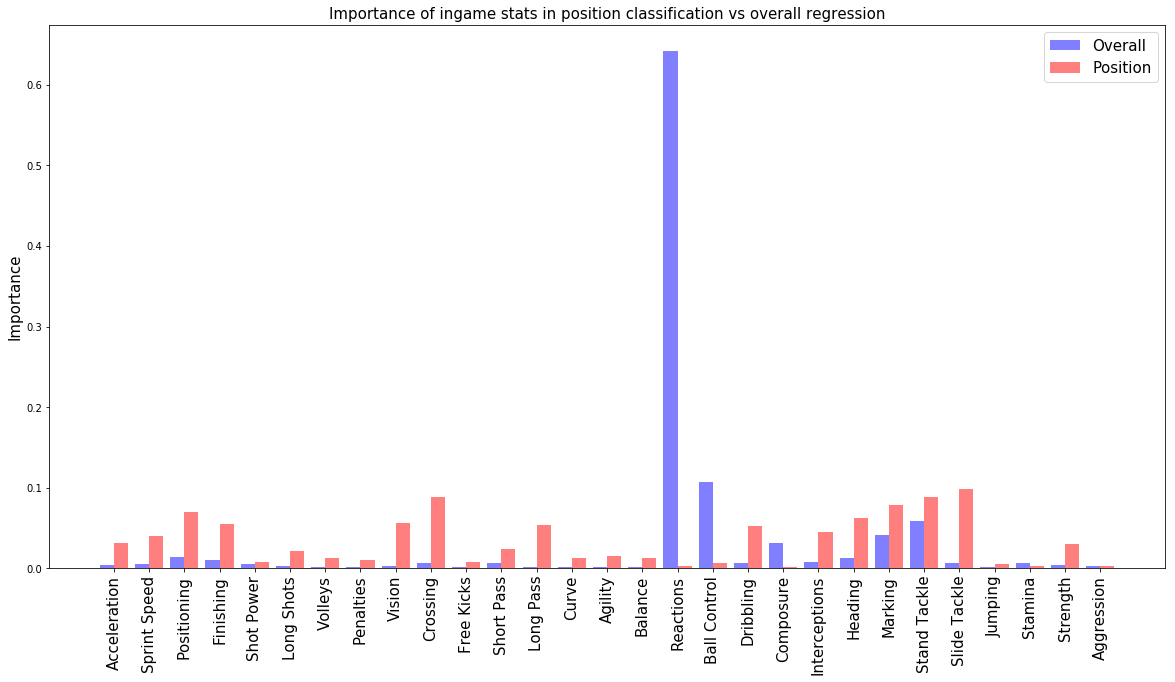

In [11]:
labels=('Acceleration', 'Sprint Speed','Positioning','Finishing','Shot Power','Long Shots','Volleys','Penalties','Vision','Crossing','Free Kicks', 'Short Pass','Long Pass','Curve',"Agility",'Balance','Reactions','Ball Control','Dribbling','Composure','Interceptions','Heading','Marking','Stand Tackle','Slide Tackle','Jumping','Stamina','Strength','Aggression')
pos = np.arange(len(labels))
width = .4 
fig, ax = plt.subplots(figsize=(20, 10))
#sub plot for the overall regression feature importances
overall = ax.bar(pos, overall_rnd_clf.feature_importances_, width, align='center', alpha=0.5, color = 'Blue')
#sub plot for the position classification feature importances
position = ax.bar(pos+width, position_rnd_clf.feature_importances_, width, align='center', alpha=0.5, color = 'Red')

ax.set_xticks(pos + width / 2)
ax.set_xticklabels(labels,rotation=90, fontsize=15)
#The highest feature for the regression makes the rest of the data hard to see, so scale it
#ax.set_ylim([0,.2])
ax.legend((overall[0],position[0]), ('Overall','Position'),fontsize=15)
ax.set_ylabel('Importance',fontsize=15)
ax.set_title('Importance of ingame stats in position classification vs overall regression',fontsize=15)
plt.show()


This graph seems to justify Nepenthez’s claims about reactions are ball control. What we see here is that reactions and ball control are the main factors when looking at a player’s overall rating. Standing tackle and marking are also significant, and when we look at the position feature weights this makes sense. It is easy to distinguish center backs when classifying position, because they are the ones with high defending stats. Similarly, standing tackle and marking are a good indicator of rating, because the only players that have high stats in this area are high rated center backs. 

Pace and physical and even passing have almost no relevance when looking at a players overall rating. So when we compare Pique and Sissoko and say that Sissoko has better base card stats, this analysis would say that this doesn’t really matter. To further emphasize the point, let’s look at the average rating of the top 100 players sorted by pace, and by reactions.  

In [114]:
overall = reactions.columns.get_loc("overall")

reactions = result.sort_values('reactions', ascending=False)
top_players_reactions = reactions.iloc[:100, overall]
print("Average rating reactions: ", np.mean(top_players_reactions))
pace = result.sort_values('pac', ascending=False)
top_players_pace = pace.iloc[:100, overall]
print("Average rating pace: ", np.mean(top_players_pace))

Average rating reactions:  84.67
Average rating pace:  74.16


The top 100 players with the best reactions are a full 10 overall rating points higher than the top 100 players with the best pace on average. 

## Positions

The next question is how much does each stat matter by position? Do reactions and ball control matter for all positions? To find out, I ran the same regression on each category of players.

In [34]:
cb_labels = cb["overall"]
cb_data = cb.loc[:,in_games]

cb_rnd_clf = RandomForestRegressor(n_estimators = 100, max_depth=30, min_samples_leaf=2, min_samples_split=2)
cb_rnd_clf.fit(cb_data, cb_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
wb_labels = wb["overall"]
wb_data = wb.loc[:,in_games]

wb_rnd_clf = RandomForestRegressor(n_estimators = 100, max_depth=30, min_samples_leaf=2, min_samples_split=2)
wb_rnd_clf.fit(wb_data, wb_labels)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [36]:
mid_labels = mid["overall"]
mid_data = mid.loc[:,in_games]

mid_rnd_clf = RandomForestRegressor(n_estimators = 100, max_depth=30, min_samples_leaf=2, min_samples_split=2)
mid_rnd_clf.fit(mid_data, mid_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [38]:
wingers_labels = wingers["overall"]
wingers_data = wingers.loc[:,in_games]

wingers_rnd_clf = RandomForestRegressor(n_estimators = 100, max_depth=30, min_samples_leaf=2, min_samples_split=2)
wingers_rnd_clf.fit(wingers_data, wingers_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
st_labels = st["overall"]
st_data = st.loc[:,in_games]

st_rnd_clf = RandomForestRegressor(n_estimators = 100, max_depth=30, min_samples_leaf=2, min_samples_split=2)
st_rnd_clf.fit(st_data, st_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Below is a graph of each player type and their corresponding feature significances. 

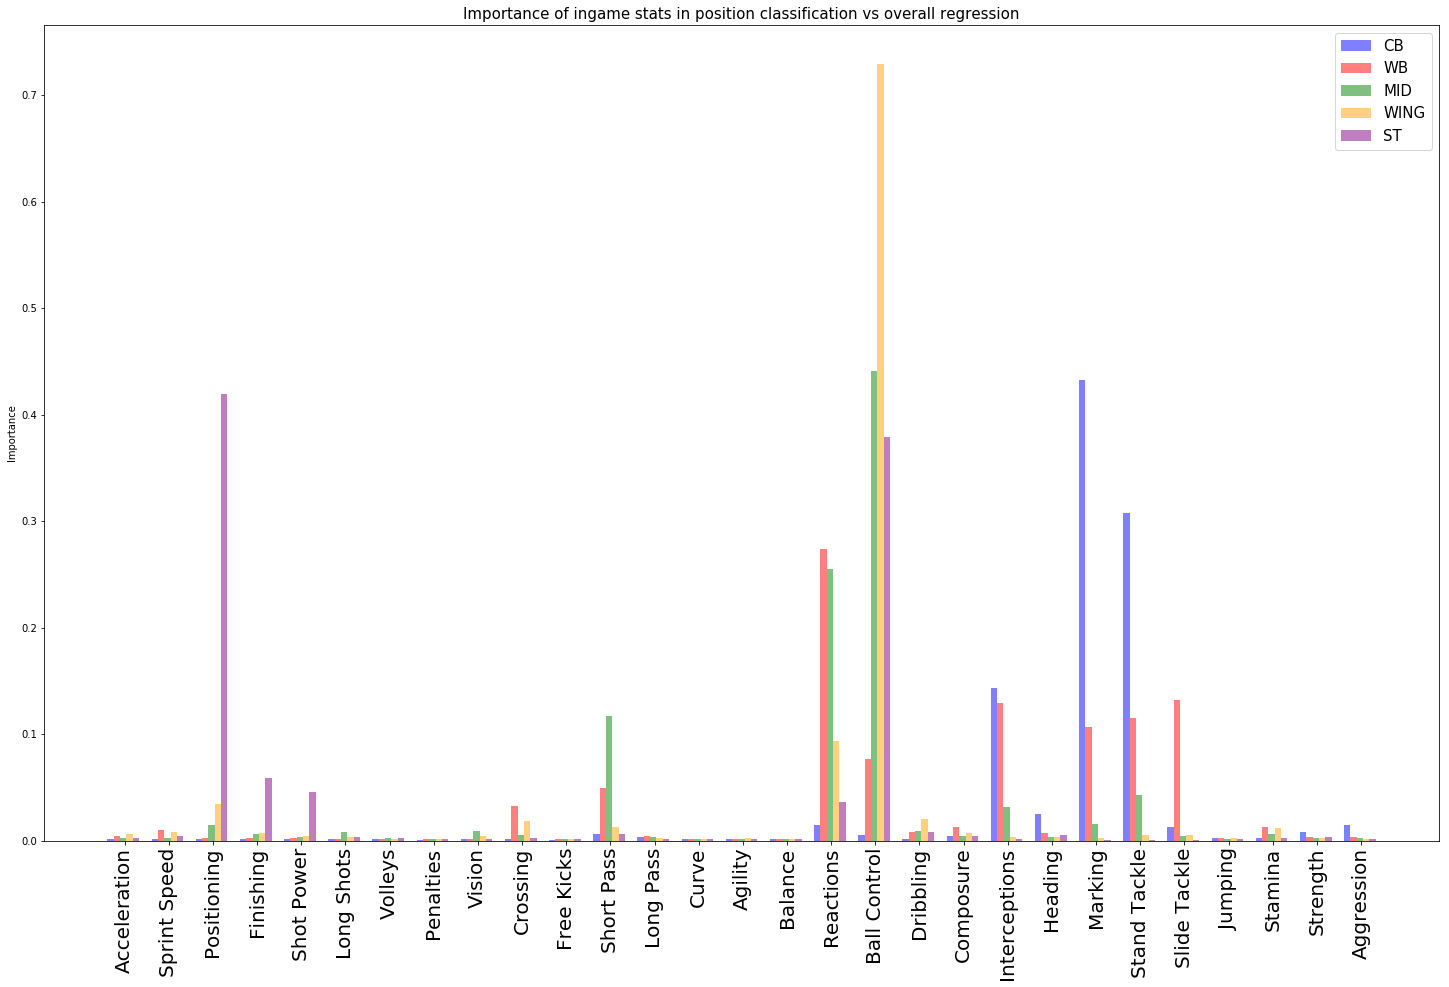

In [73]:
labels=('Acceleration', 'Sprint Speed','Positioning','Finishing','Shot Power','Long Shots','Volleys','Penalties','Vision','Crossing','Free Kicks', 'Short Pass','Long Pass','Curve',"Agility",'Balance','Reactions','Ball Control','Dribbling','Composure','Interceptions','Heading','Marking','Stand Tackle','Slide Tackle','Jumping','Stamina','Strength','Aggression')
pos = np.arange(len(labels))
pos = pos *7
width = 1
fig, ax = plt.subplots(figsize=(25, 15))

cb = ax.bar(pos-width*2, cb_rnd_clf.feature_importances_, width, align='center', alpha=0.5, color = 'Blue')

wb = ax.bar(pos-width, wb_rnd_clf.feature_importances_, width, align='center', alpha=0.5, color = 'Red')

mid = ax.bar(pos, mid_rnd_clf.feature_importances_, width, align='center', alpha=0.5, color = 'Green')

win = ax.bar(pos+width, wingers_rnd_clf.feature_importances_, width, align='center', alpha=0.5, color = 'Orange')

st = ax.bar(pos+width*2, st_rnd_clf.feature_importances_, width, align='center', alpha=0.5, color = 'Purple')

ax.set_xticks(pos+width/5)
ax.set_xticklabels(labels,rotation=90, fontsize=20)
ax.legend((cb[0],wb[0],mid[0], win[0],st[0]), ('CB','WB','MID','WING','ST'),fontsize=15)
ax.set_ylabel('Importance',fontsize=10)
ax.set_title('Importance of ingame stats in position classification vs overall regression',fontsize=15)
plt.show()


Reactions and ball control are still the two highest weighted features in general. This graph further emphasizes that the only thing that truly affects the overall rating of center backs besides reactions and ball control is defensive stats. Passing, the other dribbling stats, pace and shooting do not affect how highly they are rated. 

Unsurprisingly, the same can be said about strikers for shooting. Positioning, finishing and shot power have a large influence, while defending, pace, physical and passing do not.

### Piqué and Sissoko Revisited

<table>
    <tr>
        <td><img src="./images/pique.jpg" alt="Pique" style="width: 150px;"/></td>
        <td style="width:100px"> </td>
        <td><img src="./images/sissoko.jpg" alt="Sissoko" style="width: 150px;"/></td>
    <tr>
</table>

Given what we now know, the ratings of these two cards is are surprising. Piqué has high defending, 84 reactions, and 78 ball control. Sissoko's two highest stats on the other hand are pace and physical, both of which barely affect overall rating. He also only has 77 reactions and 76 ball control, which align with his rating. If we look at two other stats that have a higher impact on wingers, dribbling and positioning, we see that he has 78 and 76 respectively. These both align with his overall rating. Having looked at the most significant features when performing a regression on rating, Piqué and Sissoko's overall rating actually makes a lot of sense.

Another example that has recently been talked about is IF Kramer vs IF Can
<table>
    <tr>
        <td><img src="./images/can.jpg" alt="Pique" style="width: 150px;"/></td>
        <td style="width:100px"> </td>
        <td><img src="./images/kramer.jpg" alt="Sissoko" style="width: 150px;"/></td>
    <tr>
</table>

Can has far better stats the Kramer in every area when just looking at the card, yet they are the same overall rating. When we look at the relevant in-game stats however, it makes much more sense.

<table>
    <tr>
        <td style="text-align:left"></td>
        <td style="text-align:left">Can</td>
        <td style="text-align:left">Kramer</td>
    </tr>      
    <tr>
        <td style="text-align:left">Ball Control</td>
        <td>83</td>
        <td>83</td>
    </tr>
    <tr>
        <td style="text-align:left">Reactions</td>
        <td>79</td>
        <td>85</td>
    </tr>
    <tr>
        <td style="text-align:left">Short Pass</td>
        <td>84</td>
        <td>83</td>
    </tr>
    <tr>
        <td style="text-align:left">Stand Tackle</td>
        <td>83</td>
        <td>83</td>
    </tr>
    <tr>
        <td style="text-align:left">Interceptions</td>
        <td>82</td>
        <td>82</td>
    </tr>
</table>

The two players are nearly identical in these key stats, and that is why they are the same overall rating. While Can in better in almost every other in-game stat by a wide margin, those stats are not significant when calculating overall rating. 

# Conclusion

ESPN interviewed Michael Mueller-Moehring in 2016 just prior to the release of FIFA 17. He is the lead man for scouting players and giving them ratings. One of his quotes is extremely insightful. 

> A case is Thomas Muller, who isn't good at anything, really, apart from his positioning...He always finds the right spot on the pitch, it's amazing. But he's not a great dribbler and he can't really strike the ball properly -- his finishing is sometimes really, really off. Shot power is not his strength as well. So if you rate Thomas Muller properly, he ends up with a rating that we say doesn't make sense. It's too low.

This sums up the problem with player ratings perfectly. Sissoko in real life is probably is faster, stronger, a better shooter, dribbler, and maybe even passer than Piqué. However, no one would argue that Sissoko is a better player in real life than Piqué. So how do you make up the discrepancy? The answer is in the in-game stats. EA weight certain stats much higher in the overall rating calculation so that overall rating reflects real life performance, even if the other stats don't. 

The fact that Mueller-Moehring says that the only thing that Thomas Muller is good at is positioning is very revealing. Looking at the feature importances, positioning is the highest weighted stat for strikers, and Muller has 93 positioning. EA specifically weight that stat highly for Muller and for players like him. Muller also happens to have high ball control and extremely high reactions. In conclusion, a players overall rating has nothing to do with their face card stats. Instead, a EA weight a select few in-game stats very highly so that they can give a high rating to players who are good in real, while still reflecting their real-world performance in other stats.
